# Detecting Signatures From Scanned Documents

End-to-end object detection pipeline

In [8]:
%pip install labelme albumentations tensorflow tensorflow-gpu opencv-python matplotlib

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [50 lines of output]
      Traceback (most recent call last):
        File "C:\Users\sinea\AppData\Local\Temp\pip-build-env-so66917l\overlay\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "C:\Users\sinea\AppData\Local\Temp\pip-build-env-so66917l\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "C:\Users\sinea\AppData\Local\Temp\pip-build-env-so66917l\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "C:\Users\sinea\AppData\Local\Temp\pip-build-env-so66917l\overlay\Lib\site-packages\

In [1]:
#import required libraries

import cv2
import os
import time
import uuid #uniform unique identifier, create unique filenames

import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

import splitfolders

In [5]:
!labelme  #opens gui where can tag images

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\sinea\.labelmerc


Limit GPU memory growth

In [12]:
#to ensure we don't get too many out of memory errors, set GPU consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
tf.config.list_physical_devices('GPU') 

[]

Turns out there are no GPU's available anyway

### Load images into TF data pipeline

In [2]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [3]:
#function to load images
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,[1200, 1575], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  #resize the images so can add to batch later on
    return img

In [4]:
images = images.map(load_images)

In [5]:
 images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [249, 249, 249],
        ...,
        [235, 235, 235],
        [243, 243, 243],
        [246, 246, 246]],

       [[  0,   0,   0],
        [ 14,  14,  14],
        [ 21,  21,  21],
        ...,
        [255, 255, 255],
        [243, 243, 243],
        [243, 243, 243]],

       [[  0,   0,   0],
        [  7,   7,   7],
        [  8,   8,   8],
        ...,
        [255, 255, 255],
        [250, 250, 250],
        [252, 252, 252]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 20,  20,  20],
        [  3,   3,   3],
        [249, 249, 249]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [251, 251, 251]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

Visualise images with matplotlib

In [6]:
img_generator = images.batch(4).as_numpy_iterator()  #images generate 4 images at a time

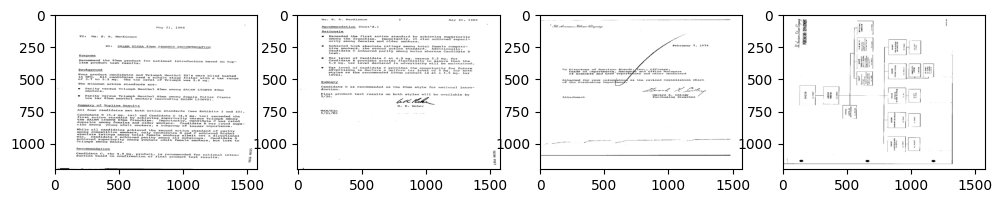

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(12,10))

ax = ax.flatten()
for idx, image in enumerate(img_generator.next()):
    ax[idx].imshow(image)
plt.show()

Split into train, test and val datasets

- 80% for training
- 10% for testing
- 10% for validation

In [20]:
splitfolders.ratio('data', output="data", seed=1337, ratio=(0.8, 0.1,0.1))

Copying files: 478 files [00:01, 421.12 files/s]


# Augment images to create larger dataset

In [21]:
import albumentations as alb

In [48]:
#define augmentation pipeline

transformer = alb.Compose([alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2),
                          alb.VerticalFlip(p=0.5), alb.RandomGamma(p=0.2)],
                          bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [103]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):      #get every image from train, test and val folders
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]    #default label is no label exists
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):                                 #check if label exists for image as not all have signatures
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]     #extract coordinates from json label file and change into vector 
            coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))

        try: 
            for x in range(10):   #create 10 augmented images for each image
                augmented = transformer(image=img, bboxes=[coords], class_labels=["Signature"])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0    #if no label then set class to 0
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]   #transform the labels
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)  #write new annotations down

        except Exception as e:
            print(e)

Expected x_min for bbox [1.8926339285714282, 3.522767857142857, 2.746428571428571, 3.9319940476190474, 'Signature'] to be in the range [0.0, 1.0], got 1.8926339285714282.
Expected y_min for bbox [0.9401939655172413, 1.5328663793103448, 1.5490301724137931, 1.741199712643678, 'Signature'] to be in the range [0.0, 1.0], got 1.5328663793103448.
Expected x_min for bbox [2.4, 6.266666666666667, 3.2875, 6.45, 'Signature'] to be in the range [0.0, 1.0], got 2.4.
Expected x_min for bbox [1.4601293103448278, 1.5723778735632183, 1.745689655172414, 1.7950790229885056, 'Signature'] to be in the range [0.0, 1.0], got 1.4601293103448278.
Expected y_min for bbox [0.1712962962962962, 2.1195216049382717, 0.8657407407407408, 2.405015432098766, 'Signature'] to be in the range [0.0, 1.0], got 2.1195216049382717.
Expected y_min for bbox [0.7435344827586207, 1.8381824712643677, 1.1341594827586206, 1.9710847701149423, 'Signature'] to be in the range [0.0, 1.0], got 1.8381824712643677.
Expected y_min for bbox 

KeyboardInterrupt: 

# Load augmented data into tf dataset

In [81]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [119]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (240,200)))  #compress files so nn is more efficient 
train_images = train_images.map(lambda x: x/255)  #scale image so we can apply sigmoid activation, values between (0,1) 

In [120]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (240,200)))
test_images = test_images.map(lambda x: x/255)

In [121]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (240,200)))
val_images = val_images.map(lambda x: x/255)

# Prepare the labels

In [122]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']  #exatrct class and bounding box

In [123]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))   #passes file path and returns class and coords

In [124]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [125]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

Combine label and images

In [126]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2400, 2400, 300, 300, 290, 290)

In [127]:
train = tf.data.Dataset.zip((train_images, train_labels))  #zip combines the img and labels
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)   #prevents bottlenecks when loading/training

In [128]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [129]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1200)
val = val.batch(8)
val = val.prefetch(4)

In [153]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4841, 0.4934, 0.767 , 0.56  ],
        [0.5225, 0.4016, 0.754 , 0.4731],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1455, 0.1931, 0.503 , 0.278 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.526 , 0.384 , 0.776 , 0.4353],
        [0.0915, 0.5635, 0.3918, 0.617 ],
        [0.1796, 0.442 , 0.503 , 0.4956]], dtype=float16))

Check images and annotations all look okay

In [98]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [154]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [162]:
def build_model(): 
    input_layer = Input(shape=(240,200,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    sig_detection = Model(inputs=input_layer, outputs=[class2, regress2])
    return sig_detection

In [163]:
sig_detection = build_model()

In [164]:
sig_detection.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 200, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [165]:
X, y = train.as_numpy_iterator().next()

In [166]:
X.shape

(8, 240, 200, 3)

In [167]:
classes, coords = sig_detection.predict(X)

1/1 [==============================] - 1s 789ms/step


In [168]:
classes, coords

(array([[0.3892813 ],
        [0.41324106],
        [0.35104743],
        [0.4107137 ],
        [0.46142554],
        [0.45618197],
        [0.5024703 ],
        [0.487561  ]], dtype=float32),
 array([[0.44008335, 0.51669765, 0.5858312 , 0.6413215 ],
        [0.45545077, 0.49306476, 0.58157945, 0.63909113],
        [0.41760227, 0.39508963, 0.67888194, 0.665082  ],
        [0.4609615 , 0.5111497 , 0.6265268 , 0.5934958 ],
        [0.39123067, 0.45761445, 0.57175666, 0.6470399 ],
        [0.43217814, 0.55210656, 0.58369416, 0.6555018 ],
        [0.45206547, 0.5334295 , 0.625453  , 0.64527184],
        [0.38488942, 0.46020618, 0.62720203, 0.6502805 ]], dtype=float32))

define optimiser and learning rate

In [169]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [171]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

create localisation loss and classification loss

In [172]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [173]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

test loss metrics

In [174]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8443946>

In [175]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8129045>

In [176]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8443946>

In [181]:
class Sig_detection(Model): 

    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [182]:
model = Sig_detection(sig_detection)

In [183]:
model.compile(opt, classloss, regressloss)

In [185]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3


300/300 [==============================] - 729s 2s/step - total_loss: 1.4720 - class_loss: 0.6369 - regress_loss: 1.1535 - val_total_loss: 0.6939 - val_class_loss: 0.7379 - val_regress_loss: 0.3250
Epoch 2/3
300/300 [==============================] - 738s 2s/step - total_loss: 1.4174 - class_loss: 0.6142 - regress_loss: 1.1103 - val_total_loss: 0.2066 - val_class_loss: 0.2479 - val_regress_loss: 0.0827
Epoch 3/3
300/300 [==============================] - 727s 2s/step - total_loss: 1.0599 - class_loss: 0.4452 - regress_loss: 0.8373 - val_total_loss: 0.2596 - val_class_loss: 0.3481 - val_regress_loss: 0.0855


In [186]:
hist.history

{'total_loss': [1.86199951171875, 1.0616931915283203, 0.39674973487854004],
 'class_loss': [0.7520719766616821, 0.41975414752960205, 0.20758368074893951],
 'regress_loss': [1.4859634637832642, 0.8518161177635193, 0.2929579019546509],
 'val_total_loss': [0.693921685218811, 0.206620454788208, 0.25959402322769165],
 'val_class_loss': [0.7379392385482788,
  0.24791263043880463,
  0.3481334149837494],
 'val_regress_loss': [0.32495203614234924,
  0.0826641395688057,
  0.08552732318639755]}

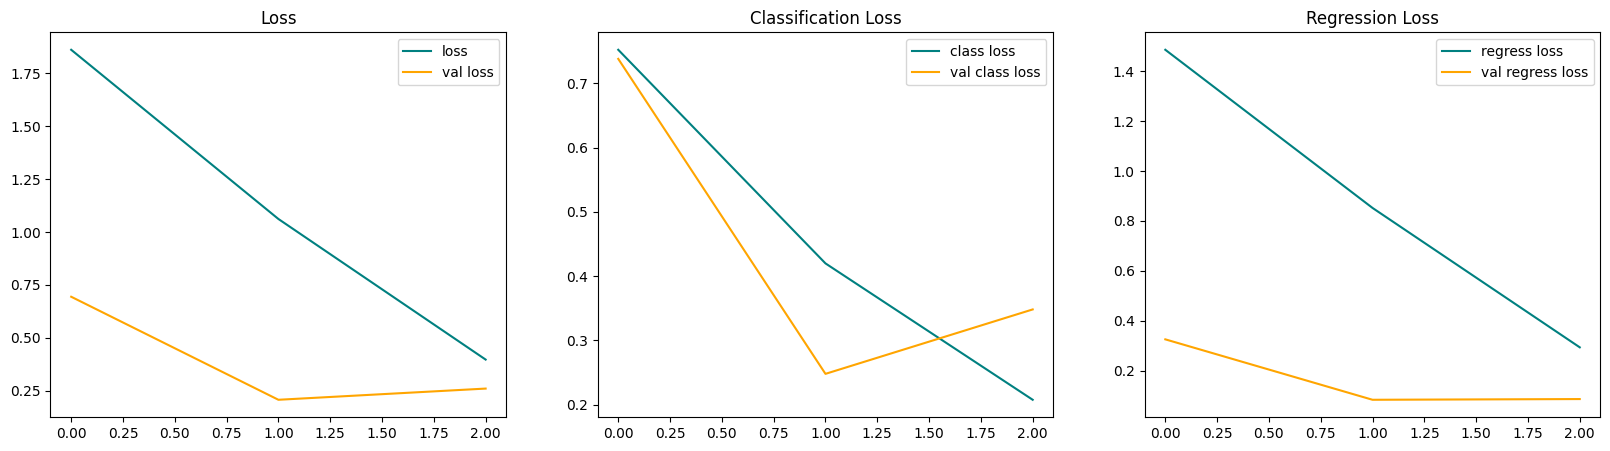

In [187]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()